# Weather forecast using LSTM

Some of interesting models, which are listed below, from the book, **Deep Learning with Python by Francois Chollet** were taken for rerun due to their design for solving time series data. Here, LSTM is used instead of GRU for these models. 

* Long short-term memory (LSTM)
* LSTM with dropouts 
* Stacking LSTM/GRU layers

In [1]:
import os
import numpy as np

import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

### Data preparation

* Data: [jena_climate](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

* This step primarily consists with
    1. Loading the downloaded data into numpy array
    2. Normalizing the data
    3. Creating generator for fitting Keras model

### 1. Loading the downloaded data into numpy array

In [3]:
data_dir = '../data'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print("INFO: # of columns: {}".format(len(header)))
print("INFO: {}".format(", ".join(header)))

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    #print("Coding: ", float_data.shape, len(values))
    float_data[i, :len(values)] = values

print("INFO: array shape {}".format(float_data.shape))

INFO: # of columns: 15
INFO: "Date Time", "p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)", "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)"
INFO: array shape (420552, 14)


### 2. Normalizing the data

In [4]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

### 3. Creating generator for fitting Keras model

In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Keras Models

1. Long short-term memory (LSTM)
2. LSTM with dropouts 
3. Stacking LSTM layers

### 1. Long short-term memory (LSTM)

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
loss_history_1 = model.fit_generator(train_gen,
                                          steps_per_epoch=500,
                                          epochs=40,
                                          validation_data=val_gen,
                                          validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
500/500 [==============================] - 130s 261ms/step - loss: 0.3137 - val_loss: 0.2725
Epoch 2/40
500/500 [==============================] - 126s 253ms/step - loss: 0.2782 - val_loss: 0.2711
Epoch 3/40
500/500 [==============================] - 124s 248ms/step - loss: 0.2649 - val_loss: 0.2750
Epoch 4/40
500/500 [==============================] - 122s 245ms/step - loss: 0.2546 - val_loss: 0.2785


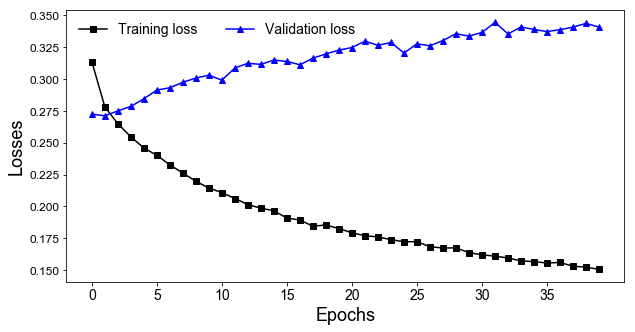

In [8]:
ts_tra_loss = loss_history_1.history['loss']
ts_val_loss = loss_history_1.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

### 2. LSTM with dropouts 

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

drop_model = Sequential()
drop_model.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
drop_model.add(layers.Dense(1))

drop_model.compile(optimizer=RMSprop(), loss='mae')
drop_model.summary()
loss_history_2 = drop_model.fit_generator(train_gen,
                                              steps_per_epoch=500,
                                              epochs=40,
                                              validation_data=val_gen,
                                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 144s 289ms/step - loss: 0.3418 - val_loss: 0.2810
Epoch 2/40
500/500 [==============================] - 137s 274ms/step - loss: 0.3057 - val_loss: 0.2728
Epoch 3/40
500/500 [==============================] - 138s 275ms/step - loss: 0.2992 - val_loss: 0.2699
Epoch 4/40
500/500 [==============================] - 137s 274ms/step - loss: 0.2951 - val_loss: 0.2682
Epoch

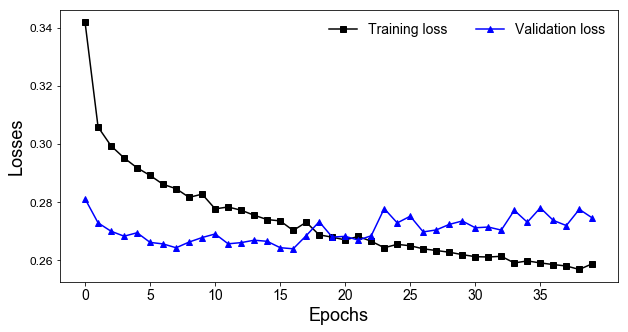

In [10]:
ts_tra_loss = loss_history_2.history['loss']
ts_val_loss = loss_history_2.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

### 3. Stacking LSTM/GRU layers

In [11]:
# stacking recurrent layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

stack_drop_model = Sequential()
stack_drop_model.add(layers.LSTM(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
stack_drop_model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
stack_drop_model.add(layers.Dense(1))

stack_drop_model.compile(optimizer=RMSprop(), loss='mae')
loss_history_3 = stack_drop_model.fit_generator(train_gen,
                                                  steps_per_epoch=500,
                                                  epochs=40,
                                                  validation_data=val_gen,
                                                  validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 309s 618ms/step - loss: 0.3412 - val_loss: 0.2790
Epoch 2/40
500/500 [==============================] - 301s 602ms/step - loss: 0.3128 - val_loss: 0.2836
Epoch 3/40
500/500 [==============================] - 303s 606ms/step - loss: 0.3054 - val_loss: 0.2714
Epoch 4/40
500/500 [==============================] - 302s 605ms/step - loss: 0.3010 - val_loss: 0.2707
Epoch 5/40
500/500 [==============================] - 300s 599ms/step - loss: 0.2961 - val_loss: 0.2680
Epoch 6/40
500/500 [==============================] - 299s 597ms/step - loss: 0.2931 - val_loss: 0.2670
Epoch 7/40
500/500 [==============================] - 296s 592ms/step - loss: 0.2900 - val_loss: 0.2648
Epoch 8/40
500/500 [==============================] - 304s 607ms/step - loss: 0.2875 - val_loss: 0.2653
Epoch 9/40
500/500 [==============================] - 292s 583ms/step - loss: 0.2859 - val_loss: 0.2733
Epoch 10/40
500/500 [==============================] - 293s 585m

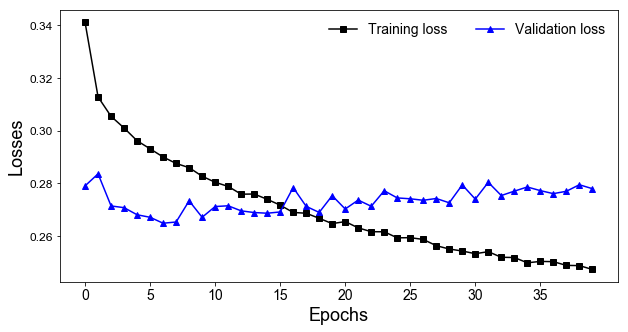

In [12]:
ts_tra_loss = loss_history_3.history['loss']
ts_val_loss = loss_history_3.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

In [13]:
fo_model = model.evaluate_generator(test_gen, test_steps)
print("INFO: LSTM: %5.3f" %fo_model)
fo_model = drop_model.evaluate_generator(test_gen, test_steps)
print("INFO: LSTM with drop: %5.3f" %fo_model)
fo_model = stack_drop_model.evaluate_generator(test_gen, test_steps)
print("INFO: Stack LSTM with drop: %5.3f" %fo_model)

INFO: LSTM: 0.346
INFO: LSTM with drop: 0.285
INFO: Stack LSTM with drop: 0.293
